In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# There are four different probabilities p for positive outcomes (r = 1). The probability for negative outcomes (r = -1) is therefore 1-p.
# In the "low-reward" task, the best action has a probability for a positive outcome of 0.2, and the other action of 0.1. 
# In the "high-reward' task, these two probabilities are 0.9 and 0.8.
ProbabilityOfPositiveOutcome = np.matrix([[.2, .1], [.9, .8]])

# Each task lasts for 800 trials and there are 5,000 iterations.
NumberOfTrials = 800
NumberOfIterations = 5000 #5000

# The temperature parameter beta is set to 0.3 for all three learners (optimistic, rational and pessimistic).
beta = 0.3

In [2]:
# LearnerIdx refers to the identity of the learner: 0 for optimistic, 1 for rational and 2 for pessimistic
for learnerIdx in range(3):

	# For the optimistic learner, the postive learning rate is set at 0.4, and the negative one at 0.1.
	if learnerIdx == 0:
		alphaPos, alphaNeg = .4, .1

	# For the rational learner, both positive and negative learning rates are set to 0.
	elif learnerIdx == 1:
		alphaPos, alphaNeg = .1, .1

	# For the pessimistic learner, the postive learning rate is set at 0.4, and the negative one at 0.1.
	else:
		alphaPos, alphaNeg = .1, .4

	# We will compute the performance on each trial for all the iterations, and the probability of switching action after 800 trials
	performance = np.nan * np.ones((NumberOfTrials, NumberOfIterations, len(ProbabilityOfPositiveOutcome)))
	switch = np.nan * np.ones((NumberOfIterations, len(ProbabilityOfPositiveOutcome)))

	# ConditionIdx refers to the task: 0 for the low-reward task, 1 for the high-reward task.
	for conditionIdx in range(len(ProbabilityOfPositiveOutcome)):

		NumberOfPositiveOutcomesBestAction = int(ProbabilityOfPositiveOutcome[conditionIdx, 0] * NumberOfTrials)
		NumberOfNegativeOutcomesBestAction = NumberOfTrials - NumberOfPositiveOutcomesBestAction
        
		NumberOfPositiveOutcomesWorstAction = int(ProbabilityOfPositiveOutcome[conditionIdx, 1] * NumberOfTrials)
		NumberOfNegativeOutcomesWorstAction = NumberOfTrials - NumberOfPositiveOutcomesWorstAction        

		for iterationIdx in range(NumberOfIterations):
            
            # The initial Q-values are set to 0. (The first element is the Q-value associated with the worst action, and the second with the best action.)
			Q = np.zeros(2)

			# We create a vector for the outcomes (r = 1 or r = -1) that will be observed on each trial
			OutcomesBestAction = np.concatenate((np.ones((NumberOfPositiveOutcomesBestAction,), dtype=np.int), - np.ones((NumberOfNegativeOutcomesBestAction,), dtype=np.int)))
			random.shuffle(OutcomesBestAction)

			OutcomesWorstAction = np.concatenate((np.ones((NumberOfPositiveOutcomesWorstAction,), dtype=np.int), - np.ones((NumberOfNegativeOutcomesWorstAction,), dtype=np.int)))
			random.shuffle(OutcomesWorstAction)            
            
			for t in range(NumberOfTrials):
                
				ProbabilityToChooseBestAction = 1/(1+np.exp((Q[0]-Q[1])/beta))
				if random.random() < ProbabilityToChooseBestAction:
					action = 1 # the chosen action is the best one.
					Outcome = OutcomesBestAction[t]
				else:
					action = 0 # the chosen action is the worst one.
					Outcome = OutcomesWorstAction[t]
				performance[t, iterationIdx, conditionIdx] = action
                
				deltaQ = Outcome - Q[action]
				Q[action] += alphaPos * deltaQ * (deltaQ >= 0) + alphaNeg * deltaQ * (deltaQ < 0)

			ProbabilityToChooseBestAction = 1/(1+np.exp((Q[0]-Q[1])/beta))
			if random.random() < ProbabilityToChooseBestAction:
				switch[iterationIdx, conditionIdx] = 1 - action
			else:
				switch[iterationIdx, conditionIdx] = action

	if learnerIdx == 0:
		meanPerformanceOptimisticLow, meanPerformanceOptimisticHigh = np.mean(performance[:,:,0], axis=1), np.mean(performance[:,:,1], axis=1)
		switchOptimistic = np.mean(switch, axis=0)
	elif learnerIdx == 1:
		meanPerformanceRationalLow, meanPerformanceRationalHigh = np.mean(performance[:,:,0], axis=1), np.mean(performance[:,:,1], axis=1)
		switchRational = np.mean(switch, axis=0)
	else:
		meanPerformancePessimisticLow, meanPerformancePessimisticHigh = np.mean(performance[:,:,0], axis=1), np.mean(performance[:,:,1], axis=1)
		switchPessimistic = np.mean(switch, axis=0)

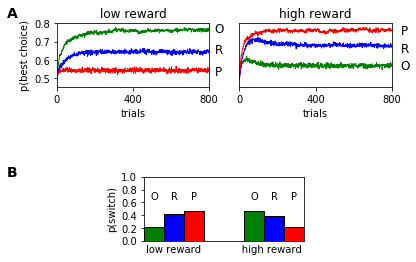

In [3]:
plt.figure(2)

# The left panel of figure 2A:
plt.subplot(3,2,1)
plt.plot(meanPerformanceOptimisticLow, 'g', linewidth=1)
plt.plot(meanPerformanceRationalLow, 'b', linewidth=1)
plt.plot(meanPerformancePessimisticLow, 'r', linewidth=1)

plt.title('low reward')
plt.axis([0, 800, .45, .8])

plt.locator_params(axis='y',nbins=8)
plt.yticks([.5, .6, .7, .8], ('0.5', '0.6', '0.7', '0.8'))
plt.ylabel('p(best choice)')

plt.xticks([0, 400, 800], ('0', '400', '800'))
plt.xlabel('trials')


# The right panel of figure 2A:
plt.subplot(3,2,2)
plt.plot(meanPerformanceOptimisticHigh, 'g', linewidth=1)
plt.plot(meanPerformanceRationalHigh, 'b', linewidth=1)
plt.plot(meanPerformancePessimisticHigh, 'r', linewidth=1)

plt.title('high reward')
plt.axis([0, 800, .45, .8])

cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_visible(False)

plt.xticks([0, 400, 800], ('0', '400', '800'))
plt.xlabel('trials')

# The figure 2B:
gs = gridspec.GridSpec(3, 4)
plt.subplot(gs[2, 1:-1])

plt.bar([1,6], switchOptimistic, width = 1, edgecolor = 'k', color='g')
plt.bar([2,7], switchRational, width = 1, edgecolor = 'k', color='b')
plt.bar([3,8], switchPessimistic, width = 1, edgecolor = 'k', color='r')

plt.axis([.5, 8.5, 0, 1])
plt.locator_params(axis='y',nbins=6)
plt.ylabel('p(switch)')
plt.xticks([])
plt.xlabel('low reward             high reward')

legendToPlot = 'ORP'
for indexLegend in range(3):
	plt.text(indexLegend+1, 0.7,legendToPlot[indexLegend], horizontalalignment='center', verticalalignment='center')
for indexLegend in range(3):
	plt.text(indexLegend+6, 0.7,legendToPlot[indexLegend], horizontalalignment='center', verticalalignment='center')

# Here I insert the text and legends around the figure:
plt.text(0.01, 0.9, 'A', fontsize=14, weight='bold', transform=plt.gcf().transFigure)
plt.text(0.01, 0.35, 'B', fontsize=14, weight='bold', transform=plt.gcf().transFigure)
for indexLegend in range(3):
	plt.text(.5, .85-.075*indexLegend, legendToPlot[indexLegend], fontsize=12, transform=plt.gcf().transFigure, horizontalalignment='center')
for indexLegend in range(3):
	plt.text(.93, .72+.06*indexLegend, legendToPlot[indexLegend], fontsize=12, transform=plt.gcf().transFigure, horizontalalignment='center')
    
plt.savefig('Figure2.png', dpi=150)
plt.show()